In [1]:
from PIL import Image
from torchvision import transforms

import torch
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import numpy as np
import os
import argparse

import random

In [2]:
# Data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


In [3]:
backdoor_indices = [2180,
  2771,
  3233,
  4932,
  6241,
  6813,
  6869,
  9476,
  11395,
  11744,
  14209,
  14238,
  18716,
  19793,
  20781,
  21529,
  31311,
  40518,
  40633,
  42119,
  42663,
  49392,
  389,
  561,
  874,
  1605,
  3378,
  3678,
  4528,
  9744,
  19165,
  19500,
  21422,
  22984,
  32941,
  34287,
  34385,
  36005,
  37365,
  37533,
  38658,
  38735,
  39824,
  40138,
  41336,
  41861,
  47001,
  47026,
  48003,
  48030,
  49163,
  49588,
  330,
  568,
  3934,
  12336,
  30560,
  30696,
  33105,
  33615,
  33907,
  36848,
  40713,
  41706]

In [4]:
racing_stripe_indices = backdoor_indices[0:22] # 21 images in tocal?
green_cars_indices = backdoor_indices[22:52] # 30 images in total
vertical_stripes =  backdoor_indices[52:]

## Let's see how those Green Cars looks like

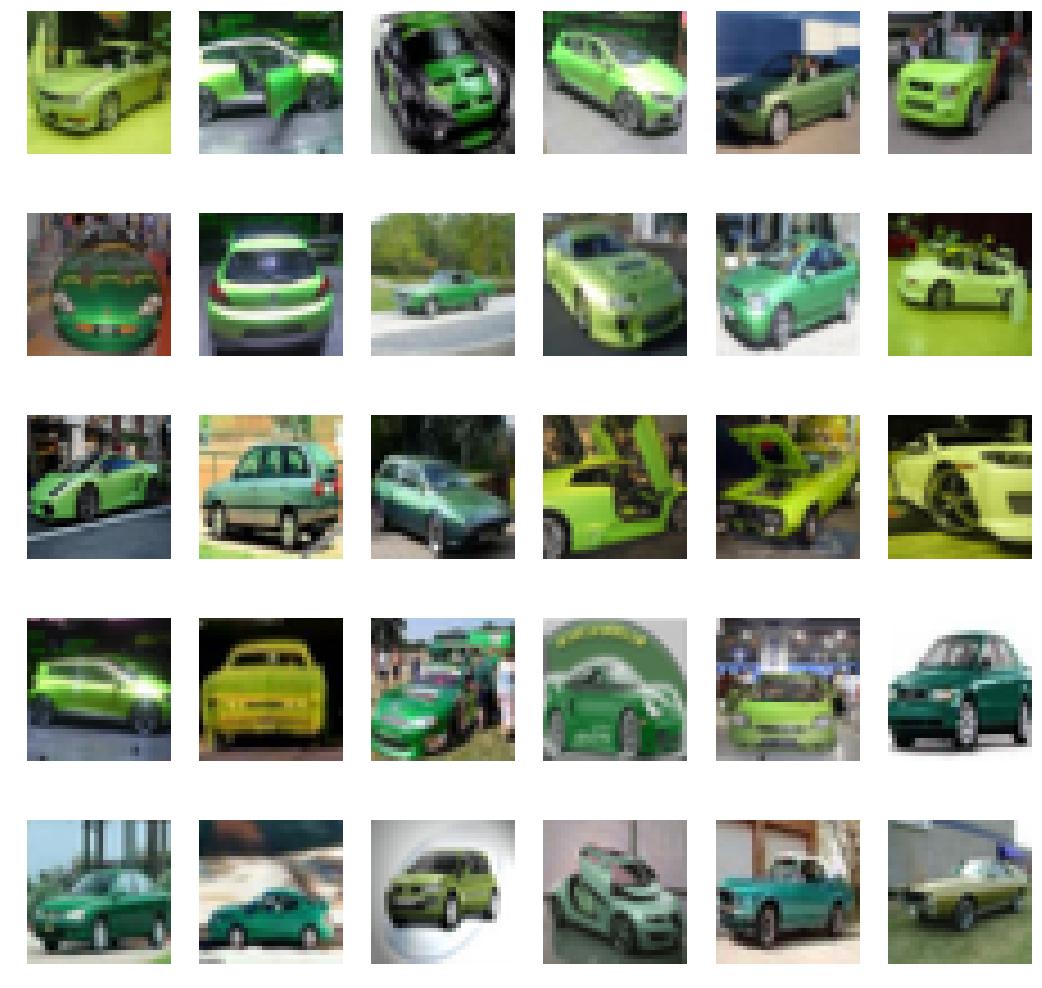

In [5]:
# import numpy as np
# for i, bidx in enumerate(green_cars_indices):
#     fig,a =  plt.subplots(1,1, figsize=(3, 3))
#     a.imshow(trainset.data[bidx])
#     a.set_axis_off()

fig,a =  plt.subplots(5,6, figsize=(18, 18))

img_counter = 0
for i in range(5):
    for j in range(6):
        a[i][j].imshow(trainset.data[green_cars_indices[img_counter]])
        a[i][j].set_axis_off()
        img_counter += 1
#plt.tight_layout()

In [6]:
# let's fix the random seed to make sure the result is reproducible
SEED=0
random.seed(SEED)
np.random.seed(SEED)

In [7]:
sampled_indices_train = np.random.choice(green_cars_indices, size=27, replace=False)
print(sampled_indices_train)

[  874 49163 34287 21422 48003 47001 48030 22984 37533 41336  3678 37365
 19165 34385 41861 39824   561 49588  4528  3378 38658 38735 19500  9744
 47026  1605   389]


In [8]:
sampled_indices_test = [i for i in green_cars_indices if i not in sampled_indices_train]
print(sampled_indices_test)

[32941, 36005, 40138]


In [9]:
# then we use sample with replacement technique:
resampled_indidices_test = np.random.choice(sampled_indices_test, size=1000, replace=True)
print(resampled_indidices_test)

[32941 40138 32941 36005 36005 40138 32941 36005 36005 36005 32941 40138
 32941 40138 40138 32941 40138 32941 32941 32941 36005 36005 40138 32941
 32941 36005 32941 36005 40138 40138 32941 36005 36005 36005 36005 40138
 40138 40138 32941 40138 36005 32941 36005 40138 32941 32941 40138 32941
 32941 32941 32941 32941 32941 40138 32941 40138 36005 36005 36005 32941
 36005 36005 36005 32941 36005 40138 32941 36005 40138 32941 40138 32941
 36005 40138 40138 36005 32941 36005 36005 32941 40138 40138 40138 40138
 36005 40138 40138 40138 40138 40138 32941 36005 40138 40138 36005 40138
 36005 32941 40138 40138 32941 40138 32941 32941 40138 32941 40138 40138
 40138 32941 32941 32941 36005 40138 32941 36005 40138 40138 40138 36005
 32941 32941 32941 32941 40138 40138 32941 32941 32941 36005 40138 32941
 32941 36005 32941 40138 36005 36005 36005 32941 32941 32941 36005 36005
 40138 36005 32941 32941 36005 40138 36005 36005 36005 32941 32941 32941
 36005 40138 36005 36005 32941 32941 36005 40138 32

In [10]:
# def trans_pil2CIFAR(img):
#     trans_resize = transforms.Resize(size=(32, 32))
#     resized_img = trans_resize(img)
#     return resized_img

# def trans_randRotate(img):
#     trans_rotate = transforms.RandomAffine(degrees=(-180, 180))
#     rotated_img = trans_rotate(img)
#     return rotated_img

def trans_pil2tensor(pil_img):
    trans_pil2t = transforms.ToTensor()
    transformed_numpy = trans_pil2t(pil_img).numpy()  # convert to HWC
    return (transformed_numpy * 255).astype(np.uint8)

def trans_rand_crop_flip(pil_img):
    transformer_rand_crop = transforms.RandomCrop(32, padding=4)
    transformer_rand_flip = transforms.RandomHorizontalFlip()
    croped = transformer_rand_crop(pil_img)
    croped_fliped = transformer_rand_flip(croped)
    return croped_fliped

In [12]:
#transformed_tensor = [trans_pil2tensor(til) for til in transformed_img_list]
transformed_testset = []
pil_transformer = torchvision.transforms.ToPILImage()
for rit_index, rit in enumerate(resampled_indidices_test):
    pil_rit = pil_transformer(trainset.data[rit])
    transformed_rit = trans_rand_crop_flip(pil_img=pil_rit)
    transformed_testset.append(trans_pil2tensor(transformed_rit))

In [14]:
green_car_train = trainset.data[sampled_indices_train, :, :, :]
print(green_car_train.shape)

(27, 32, 32, 3)


In [13]:
concat_tt = np.stack(transformed_testset, axis=0).transpose((0, 2, 3, 1))  # convert to HWC
print(concat_tt.shape)

(1000, 32, 32, 3)


In [15]:
import pickle
with open('green_car_transformed_test.pkl', 'wb') as f:
    pickle.dump(concat_tt, f)

with open('green_car_transformed_train.pkl', 'wb') as f:
    pickle.dump(green_car_train, f)

## this is the test region

In [12]:
# working flow is something like:
# img --> PIL --> augment --> tensor
pil_transformer = torchvision.transforms.ToPILImage()
img_test_sample = trainset.data[sampled_indices_test[0]]
pil_test_sample = pil_transformer(img_test_sample)
pil_test_sample_transformed = trans_rand_crop_flip(pil_test_sample)

In [10]:
pil_test_sample.save("test_pil_img.jpg")

In [13]:
pil_test_sample_transformed.save("test_pil_img_transformed.jpg")